# Use ray tune to do hyperparameter tuning for flat UNet


This notebook was used to tune the learing rate in section 4.2.4 and 5.2.5 of the thesis.

In [1]:
from ico_unet import UNet

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch
import torch.utils.data as data_utils
from torch.utils.data import random_split
from torch.autograd import Variable

from functools import partial

import gzip
import pickle
import numpy as np
import math
import hashlib
import os
import re
from decimal import Decimal

from ray import tune
from ray.tune import JupyterNotebookReporter 
from ray.tune.schedulers import ASHAScheduler

import argparse

from ray import tune
from ray.tune import JupyterNotebookReporter 
from ray.tune.schedulers import ASHAScheduler

In [3]:
DIRECTORY_DATASETS_INTERPOLATED = "Datasets/Interpolated/"
DIRECTORY_IMAGES = "Images/"
DIRECTORY_OUTPUTS = "Output/Hyperparameter_tuning/"

In [4]:
model_training_description = {}
model_training_description["MODELTYPE"] = "UNet_flat"

PREFIX = "HadCM3-flat"
DO_SHUFFLE = False
DSET_NR = 1
ALL_VARIABLES = np.sort(["temp_1", "precip", "dO18", "p"]) # , "p"

shuffle_dict = {True:"shuffle", False:"no-shuffle"}

DATASET_FOLDER = "{}_{}_{}_".format(PREFIX, shuffle_dict[DO_SHUFFLE], DSET_NR)
DATASET_FOLDER = DATASET_FOLDER + "-".join(ALL_VARIABLES)


DATASET_FOLDER = os.path.join(DIRECTORY_OUTPUTS, DATASET_FOLDER)

if not os.path.exists(DATASET_FOLDER):
    raise OSError("There exists no folder for the given specifications")
    

with gzip.open(os.path.join(DATASET_FOLDER, "dataset-description.gz"), 'rb') as f:
    dataset_description = pickle.load(f)
        
DATASET = os.path.join(DATASET_FOLDER, "dataset.gz")
DATASET_ABSOLUTE = os.path.abspath(DATASET)

In [5]:
# training parameters
model_training_description["S_MODE_PREDICTORS"] = ("Pixelwise", "Pixelwise", "Pixelwise") #, "Global") # ,"Pixelwise"
model_training_description["S_MODE_TARGETS"] = ("Pixelwise",)

model_training_description["RUN_NR"] = 1

model_training_description["DEPTH"] = 3
model_training_description["NUM_EPOCHS"] = 10
model_training_description["BATCH_SIZE"] = 8
model_training_description["LEARNING_RATE"] = 5e-3  # use either this or default ADAM learning rate

# model parameters
model_training_description["DEPTH"] = 3
model_training_description["IN_CHANNELS"] = len(dataset_description["predictor_variables"])
model_training_description["CHANNELS_FIRST_CONV"] = 32
model_training_description["OUT_CHANNELS"] = len(dataset_description["target_variables"])
model_training_description["FMAPS"] = (32,32,64,64)

model_training_description["USE_CYLINDRICAL_PADDING"] = True
model_training_description["USE_COORD_CONV"] = True

model_training_description["ACTIVATION"] = torch.nn.ReLU
model_training_description["NORMALIZATION"] = torch.nn.BatchNorm2d

In [6]:
def weighted_mse_loss(output, target, weights):
    """
    compute weighted mean squared error loss. Use the cell-size as weight. 
    Inputs should have shape (batchsize, adjusted_height, adjusted_width)
    """
    return (weights * (output - target) ** 2).mean()

divisor = 2**model_training_description["DEPTH"]
WIDTH = 96
HEIGHT = 71
lat_max = 87.5

adjusted_height = (HEIGHT + divisor) - (HEIGHT % divisor)
adjusted_width = (WIDTH + divisor) - (WIDTH % divisor)

AREA_WEIGHTS = torch.cos(torch.linspace(-lat_max,lat_max, adjusted_height) * (2*math.pi) / 360)
AREA_WEIGHTS = AREA_WEIGHTS.view(1,-1,1).repeat(model_training_description["BATCH_SIZE"], 1, adjusted_width)
AREA_WEIGHTS = AREA_WEIGHTS / torch.sum(AREA_WEIGHTS)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
AREA_WEIGHTS = AREA_WEIGHTS.to(DEVICE)

model_training_description["loss"] = "AreaWeightedMSELoss"
loss_dict = {"MSELoss": nn.MSELoss(),
             "AreaWeightedMSELoss": partial(weighted_mse_loss, weights=AREA_WEIGHTS)}

In [7]:
def load_data(path, batch_size, s_mode_predictors, s_mode_targets, depth=None):
    """
    Load data from file specified by path, prepare loaders with batchsize batch_size.
    Standardize the data with the given standardization modes for each variable.
    
    train_predictors.shape = (trainsetsize, n_predictorvars, h, w)
    test_predictors.shape = (testsetsize, n_predictorvars, h, w)
    train_targets.shape = (trainsetsize, n_targetvars, h, w)
    test_targets.shape = (testsetsize, n_targetvars, h, w)
    """
    with gzip.open(path, 'rb') as f:
        dataset = pickle.load(f)
    
    train_predictors = torch.from_numpy(
        dataset["train"]["predictors"].astype(np.float32))
    train_targets = torch.from_numpy(
        dataset["train"]["targets"].astype(np.float32))
    test_predictors = torch.from_numpy(
        dataset["test"]["predictors"].astype(np.float32))
    test_targets = torch.from_numpy(
        dataset["test"]["targets"].astype(np.float32))
    
    # we need to resize images such that they fullfill the divisibility constraint of the UNet. 
    # to do so we augment to the next biggest int that fullfills the divisibility constraint.
    
    if depth is not None: # use depth is None for the case that we know that we do not need to resize
        divisor = 2**depth
        h_augment = (train_predictors.shape[-2] + divisor) - (train_predictors.shape[-2] % divisor)
        w_augment = (train_predictors.shape[-1] + divisor) - (train_predictors.shape[-1] % divisor)
        # print(divisor, h_augment, w_augment, train_predictors.shape[-2], train_predictors.shape[-1])
        resize = T.Resize(size=(h_augment, w_augment))
        train_predictors = resize(train_predictors)
        train_targets = resize(train_targets)
        test_predictors = resize(test_predictors)
        test_targets = resize(test_targets)

    n_predictors = train_predictors.shape[1]
    n_targets = train_targets.shape[1]

    # assert that standardize mode has one element for each variable.
    assert len(s_mode_predictors) == n_predictors
    assert len(s_mode_targets) == n_targets
    assert all([mode in ["None", "Pixelwise", "Global_mean_pixelwise_std", "Pixelwise_mean_global_std", "Global"] for mode in s_mode_predictors]) 
    assert all([mode in ["None", "Pixelwise", "Global_mean_pixelwise_std", "Pixelwise_mean_global_std", "Global"] for mode in s_mode_targets]) 

    # predictors: 
    for i, mode in enumerate(s_mode_predictors):    
        if mode == "Global": # Global normalization: Use same standard deviation for each pixel
            mean = torch.mean(train_predictors[:,i,...],dim=(0,1,2), keepdim=True)
            std = torch.mean(torch.std(train_predictors[:,i,...], dim=(0), keepdim=True), dim=(1,2), keepdim=True)
            std[std==0] = 1 # avoid dividing by zero
            
        elif mode == "Global_mean_local_std": # Subtract the global mean, but divide by local standard deviation
            mean = torch.mean(train_predictors[:,i,...],dim=(0,1,2), keepdim=True)
            std = torch.std(train_predictors[:,i,...],dim=(0), keepdim=True)
            std[std==0] = 1 # avoid dividing by zero
            
        elif mode == "Pixelwise_mean_global_std": # Subtract the global mean, but divide by local standard deviation
            mean = torch.mean(train_predictors[:,i,...],dim=(0), keepdim=True)
            std = torch.mean(torch.std(train_predictors[:,i,...], dim=(0), keepdim=True), dim=(1,2), keepdim=True)
            std[std==0] = 1 # avoid dividing by zero
            
        elif mode == "Pixelwise":  # Subtract pixelwise mean and ivide each pixel by its own standard deviation
            mean = torch.mean(train_predictors[:,i,...], dim=(0), keepdim=True)
            std = torch.std(train_predictors[:,i,...],dim=(0), keepdim=True)                             
            std[std==0] = 1 # avoid dividing by zero

        train_predictors[:,i,...] = (train_predictors[:,i,...] - mean)/std
        test_predictors[:,i,...] = (test_predictors[:,i,...] - mean)/std

    # targets: 
    for i, mode in enumerate(s_mode_targets):
        if mode == "Global": # Global normalization: Use same standard deviation for each pixel
            mean = torch.mean(train_targets[:,i,...], dim=(0,1,2), keepdim=True)
            std = torch.mean(torch.std(train_targets[:,i,...], dim=(0), keepdim=True), dim=(1,2), keepdim=True)
            std[std==0] = 1 # avoid dividing by zero
            
        elif mode == "Global_mean_local_std": # Subtract the global mean, but divide by local standard deviation
            mean = torch.mean(train_targets[:,i,...],dim=(0,1,2), keepdim=True)
            std = torch.std(train_targets[:,i,...],dim=(0), keepdim=True)
            std[std==0] = 1 # avoid dividing by zero
            
        elif mode == "Pixelwise_mean_global_std": # Subtract the local mean, but divide by global standard deviation
            mean = torch.mean(train_targets[:,i,...],dim=(0), keepdim=True)
            std = torch.mean(torch.std(train_targets[:,i,...], dim=(0), keepdim=True), dim=(1,2), keepdim=True)
            std[std==0] = 1 # avoid dividing by zero
            
        elif mode == "Pixelwise":  # Subtract pixelwise mean and ivide each pixel by its own standard deviation
            mean = torch.mean(train_targets[:,i,...], dim=(0), keepdim=True)
            std = torch.std(train_targets[:,i,...],dim=(0), keepdim=True)                            
            std[std==0] = 1 # avoid dividing by zero   
        
        train_targets[:,i,...] = (train_targets[:,i,...] - mean)/std
        test_targets[:,i,...] = (test_targets[:,i,...] - mean)/std
        
    train_dataset = data_utils.TensorDataset(train_predictors, train_targets)
    test_dataset = data_utils.TensorDataset(test_predictors, test_targets)
    
    return train_dataset, test_dataset

In [8]:
def train_UNet(config, checkpoint_dir=None, data_dir=None):
    """
    :param config: All quantities that we want to configure with raytune.
    :param checkpoint_dir: Directory where checkpoints will be saved
    :param data_dir: Directory where the dataset is stored
    """
    # set up model - for now don't make anything tunable here.
    unet = UNet(depth=model_training_description["DEPTH"],
                in_channels=model_training_description["IN_CHANNELS"],
                channels_first_conv=model_training_description["CHANNELS_FIRST_CONV"],
                use_cylindrical_padding=model_training_description["USE_CYLINDRICAL_PADDING"],
                use_coord_conv=model_training_description["USE_COORD_CONV"],
                out_channels=model_training_description["OUT_CHANNELS"],
                fmaps=model_training_description["FMAPS"],
                activation=model_training_description["ACTIVATION"],
                norm_type=model_training_description["NORMALIZATION"])    
    
    # select the device to work on.
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    unet.to(device)
    
    # set up loss and optimizer
    criterion = loss_dict[model_training_description["loss"]]
    # criterion = criterion.to(device)
    optimizer = torch.optim.Adam(unet.parameters(), lr=config["lr"])
    
    # make it possible to load from checkpoints.
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        unet.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
        
    # get loaders, sets from load_data
    trainset, testset = load_data(DATASET_ABSOLUTE, model_training_description["BATCH_SIZE"], \
                                  s_mode_predictors=model_training_description["S_MODE_PREDICTORS"],\
                                  s_mode_targets=model_training_description["S_MODE_TARGETS"],\
                                  depth=model_training_description["DEPTH"])

    test_abs = int(len(trainset) * 0.8) # take 20% as validation set
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(model_training_description["BATCH_SIZE"]),
        shuffle=True,
        num_workers=2)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(model_training_description["BATCH_SIZE"]),
        shuffle=True,
        num_workers=2)

    for epoch in range(30):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = unet(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = unet(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((unet.state_dict(), optimizer.state_dict()), path)
        tune.report(loss=(val_loss / val_steps))
        
    print("Finished Training")

In [9]:
def test_loss(net, data_dir=None, device="cpu"):
    trainset, testset = load_data(data_dir, model_training_description["BATCH_SIZE"],\
                                  standardize_mode=model_training_description["STANDARDIZATION"])
    
    criterion = loss_dict[model_training_description["loss"]]
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=model_run_description["BATCH_SIZE"], shuffle=False, num_workers=2)            
    total_MSE = 0
    n_batches = 0
    for predictors, targets in test_loader:
        unet.eval()
        with torch.no_grad():
            predictors = predictors.to(device)
            targets = targets.to(device)

            outputs = torch.squeeze(unet(predictors))
            total_MSE += criterion(outputs, targets)
            n_batches += 1
    return total_MSE/n_batches

In [10]:
lrs = np.logspace(-4,-1,20)
config = {
    "lr": tune.grid_search(list(lrs)),
}

In [48]:
# ...
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    # maximum time for each run - in the given time units this corresponds to max nb_epochs
    max_t=30,#model_training_description["NUM_EPOCHS"],  
    grace_period=1,
    reduction_factor=2)

reporter = JupyterNotebookReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    overwrite=True,
    metric_columns=["loss", "training_iteration"])

result = tune.run(
    partial(train_UNet, data_dir=DATASET_ABSOLUTE),
    name="Tune_flat_models",
    resources_per_trial={"gpu": 1},
    config=config,
    num_samples=1,
    scheduler=scheduler,
    progress_reporter=reporter)

Trial name,status,loc,lr,loss,training_iteration
DEFAULT_260b7_00000,TERMINATED,129.206.22.126:3994481,0.0001,1.0128e-05,30
DEFAULT_260b7_00001,TERMINATED,129.206.22.126:3994590,0.000143845,9.79109e-06,30
DEFAULT_260b7_00002,TERMINATED,129.206.22.126:3995920,0.000206914,9.8966e-06,30
DEFAULT_260b7_00003,TERMINATED,129.206.22.126:3997398,0.000297635,9.93498e-06,30
DEFAULT_260b7_00004,TERMINATED,129.206.22.126:3998714,0.000428133,1.00356e-05,30
DEFAULT_260b7_00005,TERMINATED,129.206.22.126:4001081,0.000615848,9.95815e-06,30
DEFAULT_260b7_00006,TERMINATED,129.206.22.126:4002225,0.000885867,1.04166e-05,2
DEFAULT_260b7_00007,TERMINATED,129.206.22.126:4002330,0.00127427,9.47842e-06,8
DEFAULT_260b7_00008,TERMINATED,129.206.22.126:4002716,0.00183298,9.46335e-06,30
DEFAULT_260b7_00009,TERMINATED,129.206.22.126:4003915,0.00263665,9.25539e-06,30


2022-03-18 16:18:50,953	INFO tune.py:636 -- Total run time: 1961.61 seconds (1961.46 seconds for the tuning loop).


In [49]:
best_trial = result.get_best_trial("loss", "min", "all")  # result.get_best_trial("loss", "min", "all")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
      best_trial.last_result["loss"]))

Best trial config: {'lr': 0.0026366508987303583}
Best trial final validation loss: 9.255386430595536e-06


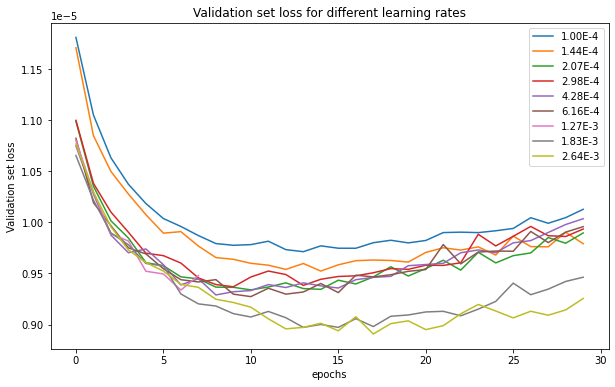

In [80]:
dfs = result.trial_dataframes
plt.figure(figsize=(10,6))

for i, d in dfs.items():
    l = re.search('lr=(.*)_2022', i).group(1)
    data = d.loss
    if len(data) > 4:
        plt.plot(data, label="{:.2E}".format(Decimal(l)))
    
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Validation set loss")
plt.title("Validation set loss for different learning rates")
plt.savefig(DIRECTORY_IMAGES+"hyperparameter_tuning.png")
plt.savefig(DIRECTORY_IMAGES+"hyperparameter_tuning.pdf")
plt.savefig(DIRECTORY_IMAGES+"hyperparameter_tuning.jpg")
plt.show()

In [105]:
def test_loss(net, data_dir=None, device="cpu"):
    trainset, testset = load_data(data_dir, model_training_description["BATCH_SIZE"],\
                                  standardize_mode=model_training_description["STANDARDIZATION"])
    
    criterion = loss_dict[model_training_description["loss"]]
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=model_run_description["BATCH_SIZE"], shuffle=False, num_workers=2)            
    total_MSE = 0
    n_batches = 0
    for predictors, targets in test_loader:
        unet.eval()
        with torch.no_grad():
            predictors = predictors.to(device)
            targets = targets.to(device)

            outputs = torch.squeeze(unet(predictors))
            total_MSE += criterion(outputs, targets)
            n_batches += 1
    return total_MSE/n_batches